In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100118673_hourly_meteostat.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2019-01-01 00:00:00,81.827423,26.1,25.2,95.0,140.0,5.4,1010.0,7.0
2019-01-01 01:00:00,81.335048,27.7,24.7,84.0,321.0,5.5,1009.8,7.0
2019-01-01 02:00:00,81.252447,28.7,24.7,79.0,329.0,7.4,1009.7,7.0
2019-01-01 03:00:00,81.323956,25.4,24.9,97.0,323.0,0.0,1010.1,7.0
2019-01-01 04:00:00,81.340817,29.5,25.0,77.0,327.0,11.1,1008.9,8.0
...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,108.370055,28.2,23.1,74.0,150.0,9.4,1011.6,2.0
2024-05-31 20:00:00,109.709303,28.2,23.1,74.0,150.0,9.4,1011.6,2.0
2024-05-31 21:00:00,110.409656,28.2,23.1,74.0,150.0,9.4,1011.6,2.0


In [6]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [7]:
scaler = StandardScaler()

In [8]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2019-01-01 00:00:00,0.664735,-0.466364,1.185728,1.343937,-0.420074,-0.741796,0.370252,0.708480
2019-01-01 01:00:00,0.650839,0.074062,0.935136,0.514419,1.720327,-0.720198,0.268182,0.708480
2019-01-01 02:00:00,0.648508,0.411829,0.935136,0.137365,1.814930,-0.309831,0.217147,0.708480
2019-01-01 03:00:00,0.650526,-0.702801,1.035373,1.494759,1.743978,-1.908102,0.421287,0.708480
2019-01-01 04:00:00,0.651002,0.682042,1.085491,-0.013457,1.791279,0.489305,-0.191132,0.927251
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-1.240539,-0.702801,0.584308,1.117705,1.377390,0.899672,-0.956655,1.146022
2022-12-31 20:00:00,-1.243250,-0.669024,0.534190,1.042294,1.436517,0.899672,-1.007690,1.146022
2022-12-31 21:00:00,-1.267635,-0.229928,0.634426,0.589829,1.590247,2.519541,-0.650446,0.927251


In [9]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco
READ_DATE,,,,,,,,
2023-01-01 00:00:00,-1.313573,-0.061044,0.885018,0.589829,1.590247,3.297079,0.166112,0.708480
2023-01-01 01:00:00,-1.371529,0.006509,0.885018,0.514419,1.519295,1.288441,-0.191132,0.708480
2023-01-01 02:00:00,-1.369317,0.276722,0.935136,0.288186,1.578422,1.698808,-0.242167,0.708480
2023-01-01 03:00:00,-1.368362,0.513159,1.085491,0.137365,1.708501,3.297079,-0.191132,0.708480
2023-01-01 04:00:00,-1.368440,0.546936,1.035373,0.061954,1.637549,2.497943,-0.497341,0.708480
...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,1.413844,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377
2024-05-31 20:00:00,1.451641,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377
2024-05-31 21:00:00,1.471407,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377


In [13]:
# Fungsi untuk melatih model dan mendapatkan metrik
def train_and_evaluate_bilstm(X_train, y_train, X_test, y_test, timesteps):
    # Siapkan data dengan timestep yang berbeda
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    # Model
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Training
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    history = model.fit(
        X_train_t, y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluation
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)

    return mse, r2

In [14]:
# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu
results = {'mse': [], 'r2': []}


In [15]:
# Evaluasi untuk setiap timestep
for ts in timesteps:
    print(f"Training with timestep {ts}...")
    mse, r2 = train_and_evaluate_bilstm(train_scaled, train_scaled['KWH_EXP'],
                                test_scaled, test_scaled['KWH_EXP'], ts)
    results['mse'].append(mse)
    results['r2'].append(r2)


Training with timestep 12...
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training with timestep 24...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Training with timestep 48...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Training with timestep 72...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Training with timestep 96...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Training with timestep 168...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


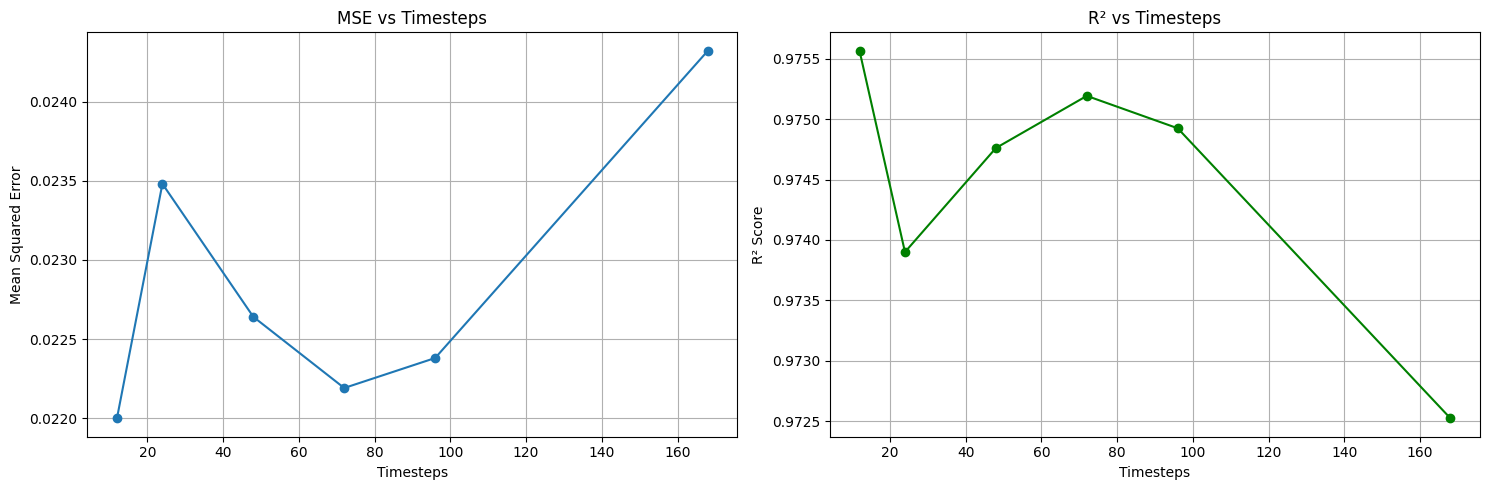

In [18]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(timesteps, results['mse'], marker='o')
plt.title('MSE vs Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# Plot R2
plt.subplot(1, 2, 2)
plt.plot(timesteps, results['r2'], marker='o', color='green')
plt.title('R² vs Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
print("\nResults Table:")
print("Timesteps | MSE | R²")
print("-" * 30)
for ts, mse, r2 in zip(timesteps, results['mse'], results['r2']):
    print(f"{ts:9d} | {mse:.6f} | {r2:.6f}")


Results Table:
Timesteps | MSE | R²
------------------------------
       12 | 0.022000 | 0.975566
       24 | 0.023481 | 0.973900
       48 | 0.022641 | 0.974761
       72 | 0.022191 | 0.975193
       96 | 0.022381 | 0.974924
      168 | 0.024321 | 0.972523


In [22]:
# Fungsi untuk melatih model dan mendapatkan metrik
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test, timesteps):
    # Siapkan data dengan timestep yang berbeda
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    # Model
    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),  # Explicit Input layer
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Training
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    history = model.fit(
        X_train_t, y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluation
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)

    return mse, r2

In [23]:
# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu
results = {'mse': [], 'r2': []}

# Evaluasi untuk setiap timestep
for ts in timesteps:
    print(f"Training with timestep {ts}...")
    mse, r2 = train_and_evaluate_lstm(train_scaled, train_scaled['KWH_EXP'],
                                test_scaled, test_scaled['KWH_EXP'], ts)
    results['mse'].append(mse)
    results['r2'].append(r2)

Training with timestep 12...
Epoch 1/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1282 - val_loss: 0.0247
Epoch 2/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0384 - val_loss: 0.0228
Epoch 3/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0345 - val_loss: 0.0201
Epoch 4/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0357 - val_loss: 0.0199
Epoch 5/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0345 - val_loss: 0.0210
Epoch 6/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0368 - val_loss: 0.0190
Epoch 7/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0331 - val_loss: 0.0185
Epoch 8/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0336 - val_loss: 0.0190
Epoch 9/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0313 - val_loss: 0.0197
Epoch 10/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0328 - val_loss: 0.0196
Epoch 11/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0327 - val_loss: 0.0206
Epoch 12/50
986/986 ━━━

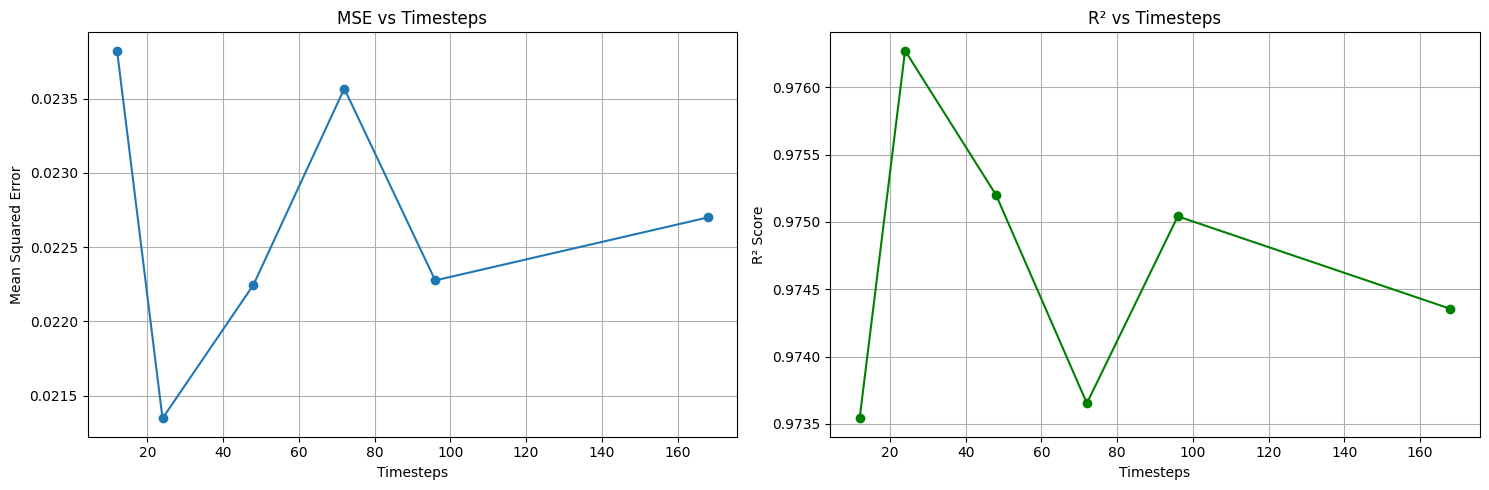

In [24]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(timesteps, results['mse'], marker='o')
plt.title('MSE vs Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# Plot R2
plt.subplot(1, 2, 2)
plt.plot(timesteps, results['r2'], marker='o', color='green')
plt.title('R² vs Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Print results in table format
print("\nResults Table:")
print("Timesteps | MSE | R²")
print("-" * 30)
for ts, mse, r2 in zip(timesteps, results['mse'], results['r2']):
    print(f"{ts:9d} | {mse:.6f} | {r2:.6f}")


Results Table:
Timesteps | MSE | R²
------------------------------
       12 | 0.023823 | 0.973542
       24 | 0.021346 | 0.976272
       48 | 0.022245 | 0.975202
       72 | 0.023568 | 0.973654
       96 | 0.022275 | 0.975042
      168 | 0.022700 | 0.974355
